# Principles of Density Based Clustering

This notebook creates several figures used to explain the concepts of density
based clustering.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
from _plotting import *
from flasc import FLASC

palette = configure_matplotlib()
palette  = sns.color_palette('cubehelix', 6)[1:]

## 1D continuous density profile

A basic example is to consider a continuous 1D density profile, providing a
density value $\lambda(x)$ for each $x \in \mathcal{R}$. Then, the density
contour clusters at $\lambda_t$ are the collection of maximal, connected sets
$\mathcal{C} = \{ x | \lambda(x) \ge \lambda_t \}$. Essentially, they are the
connected components of the level set $\lambda(x) \ge \lambda_t$. Or, the
density contour clusters at $\lambda_t$ are made from the $x$ values in the
peaks of the density distribution that reach higher than the threshold value
$\lambda_t$. The density contour tree is formed by the hierarchy in which the
contour clusters merge as $\lambda_t$ decreases. In topological terms, the
density contour tree is a join tree over a filtration from $\lambda_{max}$ to
$\lambda_{min}$.

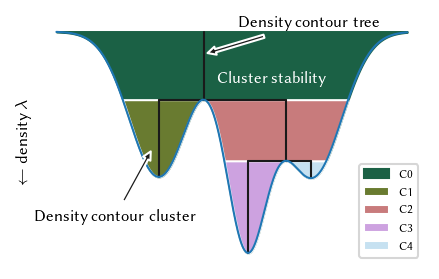

In [3]:
centers = [-0.5, 0.1, 0.55]
deviations = [0.2, 0.14, 0.2]
x = np.linspace(-1.2, 1.2, 1000)
y = np.vstack([
    sp.stats.norm(loc=mu, scale=sigma).pdf(x)
    for mu, sigma in zip(centers, deviations)
]).sum(axis=0)

idx_minima = np.where(np.r_[True, y[1:] < y[:-1]] & np.r_[y[:-1] < y[1:], True])[0][1:3]
x_minima = x[idx_minima]
y_minima = y[idx_minima]

idx_maxima = np.where(np.r_[True, y[1:] > y[:-1]] & np.r_[y[:-1] > y[1:], True])[0]
x_maxima = x[idx_maxima]
y_maxima = y[idx_maxima]


sized_fig(1/2)
plt.fill_between(x, y, 0, color=palette[0], label='C0')
plt.fill_between(x, y, y_minima[0], where=(y >= y_minima[0]) & (x < x_minima[0]), facecolor=palette[1], label='C1')
plt.fill_between(x, y, y_minima[0], where=(y >= y_minima[0]) & (x > x_minima[0]), facecolor=palette[2], label='C2')
plt.fill_between(x, y, y_minima[1], where=(y >= y_minima[1]) & (x > x_minima[0]) & (x < x_minima[1]), facecolor=palette[3], label='C3')
plt.fill_between(x, y, y_minima[1], where=(y >= y_minima[1]) & (x > x_minima[0]) & (x > x_minima[1]), facecolor=palette[4], label='C4')
plt.plot([x_minima[0], x_minima[0]], [y_minima[0], 0], linewidth=1, color='k')
plt.plot([x_maxima[0], x_maxima[0]], [y_maxima[0], y_minima[0]], linewidth=1, color='k')
plt.plot([x_maxima[0], x_minima[1]], [y_minima[0], y_minima[0]], linewidth=1, color='k')
plt.plot([x_minima[1], x_minima[1]], [y_minima[0], y_minima[1]], linewidth=1, color='k')
plt.plot([x_maxima[1], x_maxima[1]], [y_maxima[1], y_minima[1]], linewidth=1, color='k')
plt.plot([x_maxima[2], x_maxima[2]], [y_maxima[2], y_minima[1]], linewidth=1, color='k')
plt.plot([x_maxima[1], x_maxima[2]], [y_minima[1], y_minima[1]], linewidth=1, color='k')
plt.plot(x, y, linewidth=1)
plt.annotate("Density contour cluster", (x_maxima[0]-0.04, y_maxima[0] -0.4), (-1.35, 2.6), arrowprops={'arrowstyle': 'simple', 'facecolor': 'k'})
plt.annotate("Density contour tree", (x_minima[0], y_minima[0] / 3), (0.05, -0.07), arrowprops={'arrowstyle': 'simple', 'facecolor': 'k'})
plt.annotate("Cluster stability", (-0.1, 0.7), color='white')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.legend(loc='lower right')
plt.ylabel('$\leftarrow$ density $\lambda$')
plt.subplots_adjust(0.06, 0, 1, 0.96)
plt.savefig('./images/1d_density_profile.png', dpi=300)
plt.show()

## 2D discrete density

Datasets are not continuous but contain individual data points. As a result, they do not have an inherent notion of connectivity which we can use to determine whether two points are in the same density contour cluster. HDBSCAN* solves this by estimating density in terms of distance, allowing us to say all points closer than $1/\lambda_t$ are connected at $\lambda_t$.

Within this formulation, the edges that merge density contours are exactly those edges in the minimum spanning tree. So, single linkage clustering can recover the density contour tree.

In [4]:
data = np.load('./data/flared_clusterable_data.npy')

In [5]:
from sklearn.metrics import pairwise_distances

min_points = 15
distance_matrix = pairwise_distances(data)
np.fill_diagonal(distance_matrix, np.nan)
neighbours = np.argpartition(distance_matrix, min_points - 1)[:, :min_points]
core_distances = np.take_along_axis(distance_matrix, neighbours[:, -1][None], axis=0)[0]
density = 1 / core_distances

clusterer = FLASC(min_cluster_size=25).fit(data)

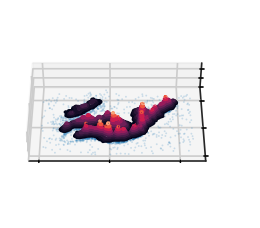

In [6]:
import matplotlib.tri as mtri

fig = sized_fig(0.245)
tri = mtri.Triangulation(data[:, 0], data[:, 1])
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(density.min(), data.shape[0]),
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(tri, density, levels=np.exp(np.linspace(np.log(30), np.log(density.max()), 10)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig("./images/density_profile.png", dpi=600)
plt.show()

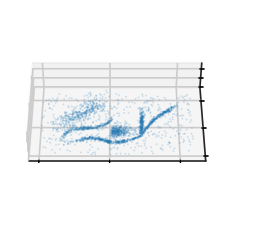

In [7]:
fig = sized_fig(0.245)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(density.min(), data.shape[0]),
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig("./images/density_profile_data.png", dpi=600)
plt.show()

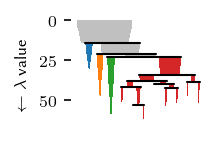

In [8]:
from hdbscan.plots import _get_leaves


def plot_cluster_tree(tree, labels, separation=0.2):
    plot_data = get_cluster_tree_data(tree, labels, separation)

    axis = plt.gca()
    axis.bar(
        plot_data["bar_centers"],
        plot_data["bar_tops"],
        bottom=plot_data["bar_bottoms"],
        width=plot_data["bar_widths"],
        color=["silver" if l < 0 else f"C{l}" for l in plot_data["bar_labels"]],
        # color='silver',
        align="center",
        linewidth=0,
    )

    drawlines = []
    for xs, ys in zip(plot_data["line_xs"], plot_data["line_ys"]):
        drawlines.append(xs)
        drawlines.append(ys)
    axis.plot(*drawlines, color="black", linewidth=1)
    axis.set_xticks([])
    for side in ("right", "top", "bottom"):
        axis.spines[side].set_visible(False)
    axis.invert_yaxis()
    axis.set_ylabel("$\leftarrow \lambda$ value")

    return axis


def get_cluster_tree_data(tree, labels, separation):
    leaves = _get_leaves(tree._raw_tree)
    last_leaf = tree._raw_tree["parent"].max()
    root = tree._raw_tree["parent"].min()

    # We want to get the x and y coordinates for the start of each cluster
    # Initialize the leaves, since we know where they go, the iterate
    # through everything from the leaves back, setting coords as we go
    if isinstance(leaves, np.int64):
        cluster_x_coords = {leaves: separation}
    else:
        cluster_x_coords = dict(zip(leaves, [separation * x for x in range(len(leaves))]))
    cluster_y_coords = {root: 0.0}

    for cluster in range(last_leaf, root - 1, -1):
        split = tree._raw_tree[["child", "lambda_val"]]
        split = split[
            (tree._raw_tree["parent"] == cluster) & (tree._raw_tree["child_size"] > 1)
        ]
        if len(split["child"]) > 1:
            left_child, right_child = split["child"]
            cluster_x_coords[cluster] = np.mean(
                [cluster_x_coords[left_child], cluster_x_coords[right_child]]
            )
            cluster_y_coords[left_child] = split["lambda_val"][0]
            cluster_y_coords[right_child] = split["lambda_val"][1]

    # We use bars to plot the 'icicles', so we need to generate centers, tops,
    # bottoms and widths for each rectangle. We can go through each cluster
    # and do this for each in turn.
    bar_centers = []
    bar_tops = []
    bar_bottoms = []
    bar_widths = []
    bar_labels = []

    cluster_bounds = {}
    scaling = np.sum(tree._raw_tree[tree._raw_tree["parent"] == root]["child_size"])
    for c in range(last_leaf, root - 1, -1):

        cluster_bounds[c] = [0, 0, 0, 0]

        c_children = tree._raw_tree[tree._raw_tree["parent"] == c]
        current_size = np.sum(c_children["child_size"])
        current_lambda = cluster_y_coords[c]
        cluster_max_size = current_size
        cluster_max_lambda = c_children["lambda_val"].max()
        cluster_min_size = np.sum(
            c_children[c_children["lambda_val"] == cluster_max_lambda]["child_size"]
        )

        total_size_change = float(cluster_max_size - cluster_min_size)
        step_size_change = total_size_change / 40

        cluster_bounds[c][0] = cluster_x_coords[c] * scaling - (current_size / 2.0)
        cluster_bounds[c][1] = cluster_x_coords[c] * scaling + (current_size / 2.0)
        cluster_bounds[c][2] = cluster_y_coords[c]
        cluster_bounds[c][3] = np.max(c_children["lambda_val"])

        last_step_size = current_size
        last_step_lambda = current_lambda

        child_order = np.argsort(c_children["lambda_val"])
        prev_i = 0
        for i, o in enumerate(child_order):
            row = c_children[o]
            if row["lambda_val"] != current_lambda and (
                last_step_size - current_size > step_size_change
                or row["lambda_val"] == cluster_max_lambda
            ):
                bar_centers.append(cluster_x_coords[c] * scaling)
                bar_tops.append(row["lambda_val"] - last_step_lambda)
                bar_bottoms.append(last_step_lambda)
                bar_widths.append(last_step_size)
                label = labels[c_children["child"][child_order[prev_i:i]]]
                label = label[np.argmax(label > -1)] if len(label) else -1
                bar_labels.append(label.min())
                last_step_size = current_size
                last_step_lambda = current_lambda
            current_size -= row["child_size"]
            current_lambda = row["lambda_val"]

    # Finally we need the horizontal lines that occur at cluster splits.
    line_xs = []
    line_ys = []

    for row in tree._raw_tree[tree._raw_tree["child_size"] > 1]:
        parent = row["parent"]
        child = row["child"]
        child_size = row["child_size"]
        sign = np.sign(cluster_x_coords[child] - cluster_x_coords[parent])
        line_xs.append(
            [
                cluster_x_coords[parent] * scaling,
                cluster_x_coords[child] * scaling + sign * (child_size / 2.0),
            ]
        )
        line_ys.append([cluster_y_coords[child], cluster_y_coords[child]])

    return {
        "bar_centers": bar_centers,
        "bar_tops": bar_tops,
        "bar_bottoms": bar_bottoms,
        "bar_widths": bar_widths,
        "bar_labels": bar_labels,
        "line_xs": line_xs,
        "line_ys": line_ys,
        "cluster_bounds": cluster_bounds,
    }


sized_fig(0.245)
# lambda_t = 25
labels = clusterer.cluster_labels_  # .hdbscan_.dbscan_clustering(1 / lambda_t)
plot_cluster_tree(clusterer.condensed_tree_, labels)
# plt.hlines(lambda_t, plt.xlim()[0], plt.xlim()[1], color='k', linestyle=':', linewidth=0.4)
plt.subplots_adjust(0.28, 0.05, 0.95, 0.95, 0, 0)
# plt.gca().invert_yaxis()
plt.savefig("./images/density_profile_hierarchy.png", dpi=600)
plt.show()

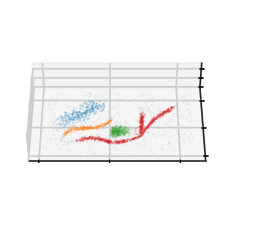

In [9]:
fig = sized_fig(0.245)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(density.min(), data.shape[0]),
    c=["silver" if l < 0 else f"C{l}" for l in labels],
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig("./images/density_profile_clustered.png", dpi=600)
plt.show()

## Detecting branches with centrality

Centrality can be used similarly to detect branch-based subgroups. Let $c(x_i)$ be point $x_i$'s centrality, which is high in the center of a cluster and low farther away. Let $e(x_i) = 1 / c(x_i)$ measure the eccentricity. Then, peaks in the eccentricity profile correspond to branches. Eccentricity contour cluster at some $e_t$ are then defined as the maximal connected sets $\{x\;|\;e(x) \ge e_t\}.$

This leaves two questions:
1. How to define eccentricity? 
2. How to define connectivity?

FLASC defines eccentricity using the distance of points in a cluster to the
weighted average (centroid) of the cluster. These distances are then reversed
and inversed to obtain the eccentricity: 

$ e(x_i) = \frac{1}{(max_{x_l \in
C_j}{d(\bar{x}_{C_j}, x_l)})- d(\bar{x}_{C_j}, x_i)} $

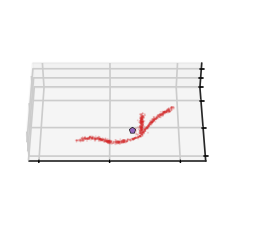

In [10]:
pts = clusterer.cluster_points_[-1]
centroid = np.average(
    data[pts], weights=clusterer.cluster_probabilities_[pts], axis=0
)

fig = sized_fig(0.245)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[pts, 0],
    data[pts, 1],
    np.repeat(density.min(), pts.shape[0]),
    color=f"C{3}",
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.scatter(
    centroid[0],
    centroid[1],
    density.min(),
    s=10,
    color=f"C{4}",
    alpha=1,
    marker="p",
    label="centroid",
    edgecolor="black",
    linewidth=0.3,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig(f"./images/eccentricity_centers.png", dpi=600, pad_inches=0)
plt.show()

Peaks in the eccentricity profile correspond to branches in the cluster. (We
apply a log-transform and offset to improve the height-map visual.)

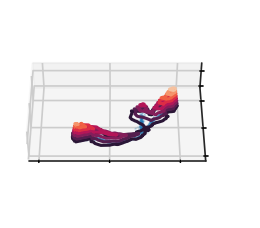

In [27]:
fig = sized_fig(0.245)
centrality = np.zeros_like(density)
tri = mtri.Triangulation(data[:, 0], data[:, 1])
centrality[pts] = np.log(1 / (0.5 + clusterer.cluster_centralities_[pts]))

ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[pts, 0],
    data[pts, 1],
    np.repeat(centrality.min(), pts.shape[0]),
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(tri, centrality, levels=np.linspace(0, centrality.max(), 10))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig(f"./images/eccentricity_profile.png", dpi=600)
plt.show()

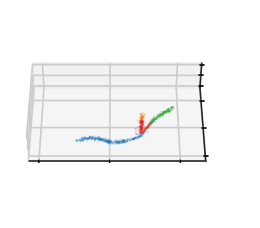

In [12]:
fig = sized_fig(0.245)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[pts, 0],
    data[pts, 1],
    np.repeat(centrality.min(), pts.shape[0]),
    c=["silver" if l < 0 else f"C{l}" for l in clusterer.branch_labels_[pts]],
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig(f"./images/eccentricity_clusters.png", dpi=600)
plt.show()

To compute the eccentricity contour tree as HDBSCAN*-style density based
clusters, a notion of connectivity is needed. FLASC provides two solutions:

1. Connect all points in a cluster nearer than the maximum distance in the
   cluster's MST. This models all connectivity in the cluster just before the
   cluster merges with somehting else. Consequently, it is the least sensitive
   to branches, as gaps at smaller scales are crossed.
2. Connect all points within the cluster's mutual-reachability MST. Effectively,
   creates a `min_samples`-nearest neighbour graph with MST edges representing
   the least ammount of connectivity that still keeps the cluster connected. As
   a result, this approach is most sensitive to branches, as smaller gaps may
   not be crossed at low `min_samples`.

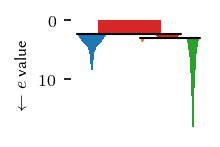

In [30]:
sized_fig(0.245)
plot_cluster_tree(
    clusterer.cluster_condensed_trees_[-1], clusterer.branch_labels_[pts], 0.8
)
plt.subplots_adjust(0.28, 0.05, 0.95, 0.95, 0, 0)
plt.ylabel('$\leftarrow e$ value')
plt.savefig(f"./images/eccentricity_hierarchy.png", dpi=600)
plt.show()

Cluster and branch labels are combined to differentiate both kinds of
sub-groups.

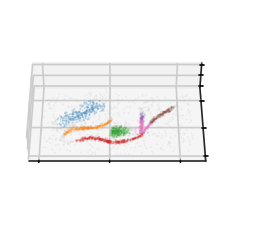

In [14]:
fig = sized_fig(0.245)
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=45, azim=-90)
ax.scatter(
    data[:, 0],
    data[:, 1],
    np.repeat(centrality.min(), data.shape[0]),
    c=["silver" if l < 0 else f"C{l}" for l in clusterer.labels_],
    s=0.8,
    alpha=0.2,
    edgecolor="none",
    linewidth=0,
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim(zlim)
ax.set_box_aspect(aspect=(5, 3, 1))
plt.subplots_adjust(-0.1, -0.3, 1.1, 1.3)
plt.savefig("./images/flasc_labels.png", dpi=600)
plt.show()